In [355]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [356]:
df_titanic = pd.read_csv('/kaggle/input/titanic/train.csv')
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


DATA ENGINEERING - Understanding the Dataset

<Axes: >

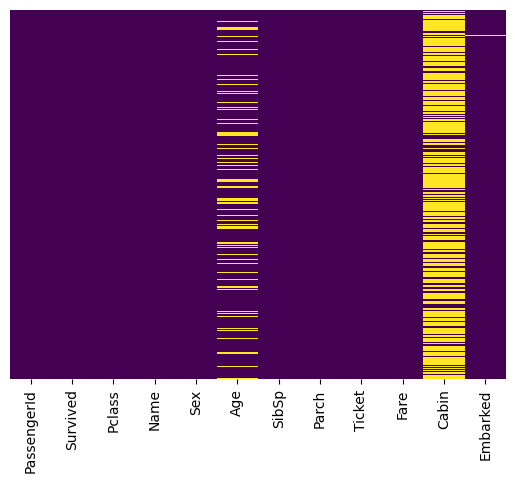

In [357]:
# Create heatmap using seaborn to understand the missing values in the dataset
sns.heatmap(df_titanic.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<Axes: xlabel='Survived', ylabel='count'>

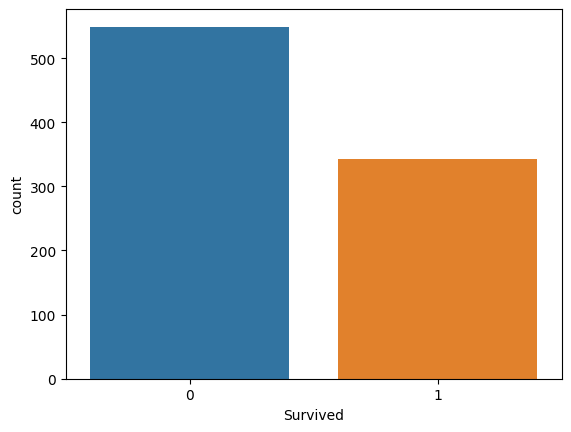

In [358]:
# Survived vs. Deceased
sns.countplot(x='Survived', data=df_titanic)

<Axes: xlabel='Survived', ylabel='count'>

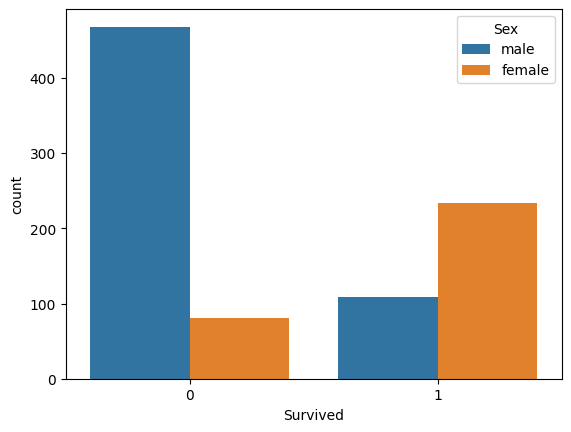

In [359]:
# From the training dataset, know the sexes that Survived and the Deceased: Male vs. Female
sns.countplot(x='Survived', hue='Sex', data=df_titanic)

<Axes: xlabel='Survived', ylabel='count'>

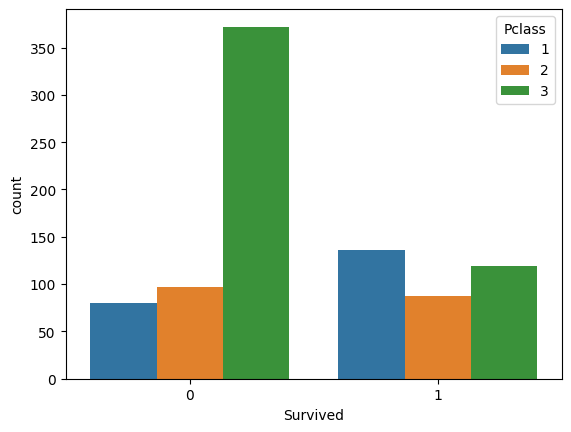

In [360]:
# Understand the class of people that survived
sns.countplot(x='Survived', hue='Pclass', data=df_titanic)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

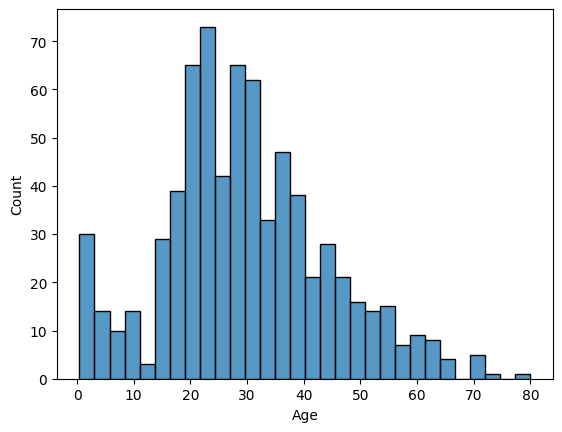

In [361]:
# Understand the age distribution of the People in the titanic ship
#df_titanic['Age'] = df_titanic['Age'].dropna()
sns.histplot(df_titanic['Age'].dropna(), kde=False, bins=30)

In [362]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Data Preprocessing

<Axes: xlabel='Pclass', ylabel='Age'>

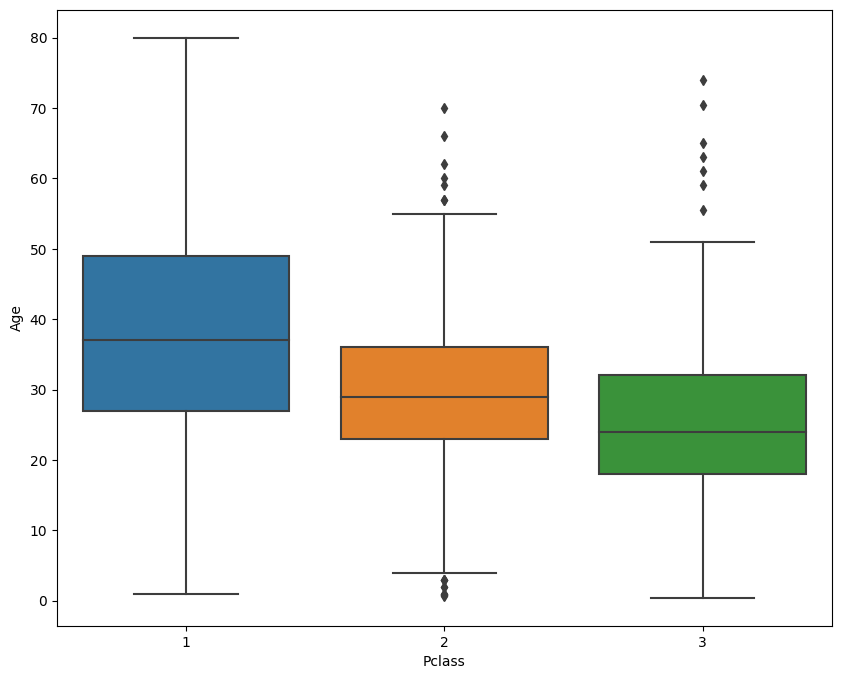

In [363]:
# Examine the mean ages of each of the Pclass
plt.figure(figsize=(10, 8))
sns.boxplot(x='Pclass', y='Age', data=df_titanic)

In [364]:
# This function replaces NaN age values with the median age in each class
def fill_missing_age_with_mean(cols):
    if pd.isnull(cols.iloc[0]):
        if(cols.iloc[1] == 1):
            return 37
        if(cols.iloc[1] == 2):
            return 29
        if(cols.iloc[1] == 3):
            return 25
    else:
        return cols.iloc[0]

In [365]:
# Apply the function to the Age column
df_titanic['Age'] = df_titanic[['Age', 'Pclass']].apply(fill_missing_age_with_mean, axis=1)

<Axes: >

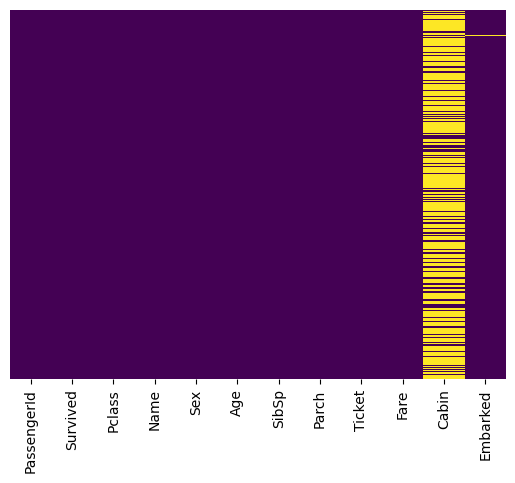

In [366]:
# Confirm that there is no more missing data in the age column
sns.heatmap(df_titanic.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [367]:
# Drop all missing data
df_titanic.dropna(inplace=True)

<Axes: >

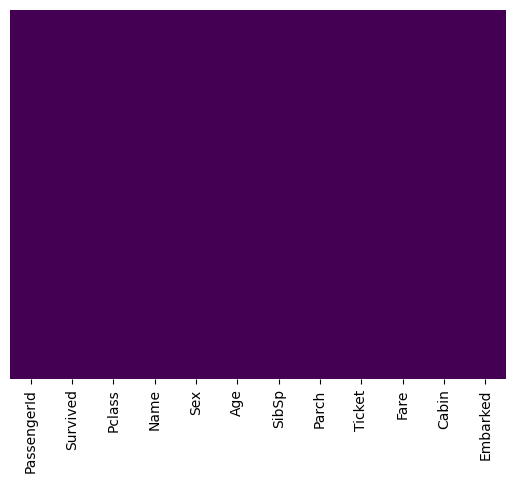

In [368]:
# Confirm that there is no missing data on the dataframe
sns.heatmap(df_titanic.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [369]:
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [370]:
# Change the data type of the Sex column to Numeric
df_titanic['Sex'] = df_titanic['Sex'].map({'male': 0, 'female': 1})
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",1,58.0,0,0,113783,26.5500,C103,S


In [371]:
# Drop the columns not needed in the dataframe
df_titanic.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df_titanic.head()

,Survived,Pclass,Sex,Age,Fare
1,1,1,1,38.0,71.2833
3,1,1,1,35.0,53.1000
6,0,1,0,54.0,51.8625
10,1,3,1,4.0,16.7000
11,1,1,1,58.0,26.5500


Training of the Model

In [372]:
# Select the Predictor variables and the Target variable
X = df_titanic.drop('Survived', axis=1)
y = df_titanic['Survived']

In [373]:
X

,Pclass,Sex,Age,Fare
1,1,1,38.0,71.2833
3,1,1,35.0,53.1000
6,1,0,54.0,51.8625
10,3,1,4.0,16.7000
11,1,1,58.0,26.5500
...,...,...,...,...
871,1,1,47.0,52.5542
872,1,0,33.0,5.0000
879,1,1,56.0,83.1583
887,1,1,19.0,30.0000


In [374]:
# Split the training dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [375]:
log_reg = LogisticRegression()

In [376]:
log_reg.fit(X_train, y_train)

LogisticRegression()

In [377]:
y_pred = log_reg.predict(X_test)

Model Evaluation

In [378]:
# Evaluate the model built
evaluation = classification_report(y_test, y_pred)
print(evaluation)

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.94      0.88      0.91        33

    accuracy                           0.85        41
   macro avg       0.77      0.81      0.79        41
weighted avg       0.87      0.85      0.86        41



In [379]:
log_reg_accuracy_score = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy Score: {log_reg_accuracy_score}')

Logistic Regression Accuracy Score: 0.8536585365853658


TESTING THE MODEL ON THE TEST DATASET

In [380]:
# Load the Test dataset

df_titanic_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_titanic_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [381]:
passengerIds = df_titanic_test['PassengerId']
passengerIds

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [382]:
test_X = df_titanic_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], axis=1)
test_X.head()

,Pclass,Sex,Age,Fare
0,3,male,34.5,7.8292
1,3,female,47.0,7.0000
2,2,male,62.0,9.6875
3,3,male,27.0,8.6625
4,3,female,22.0,12.2875


In [383]:
# Change the data type of the Sex column to Numeric
test_X['Sex'] = test_X['Sex'].map({'male': 0, 'female': 1})
test_X

,Pclass,Sex,Age,Fare
0,3,0,34.5,7.8292
1,3,1,47.0,7.0000
2,2,0,62.0,9.6875
3,3,0,27.0,8.6625
4,3,1,22.0,12.2875
...,...,...,...,...
413,3,0,NaN,8.0500
414,1,1,39.0,108.9000
415,3,0,38.5,7.2500
416,3,0,NaN,8.0500


In [384]:
# Apply the function to the Age column
test_X['Age'] = test_X[['Age', 'Pclass']].apply(fill_missing_age_with_mean, axis=1)
test_X

,Pclass,Sex,Age,Fare
0,3,0,34.5,7.8292
1,3,1,47.0,7.0000
2,2,0,62.0,9.6875
3,3,0,27.0,8.6625
4,3,1,22.0,12.2875
...,...,...,...,...
413,3,0,25.0,8.0500
414,1,1,39.0,108.9000
415,3,0,38.5,7.2500
416,3,0,25.0,8.0500


<Axes: >

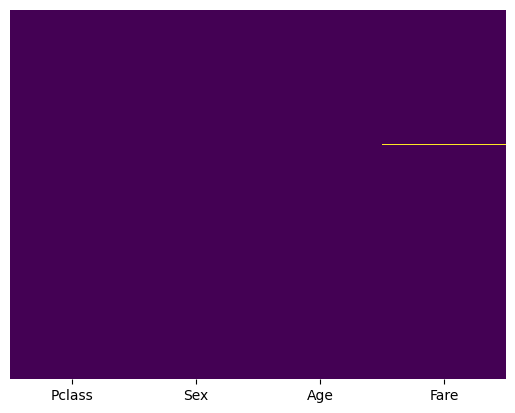

In [385]:
# Confirm that there is no missing data on the dataframe
sns.heatmap(test_X.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [386]:
# Fill the NaN values in Fare column with the median
test_X['Fare'] = test_X['Fare'].median()

<Axes: >

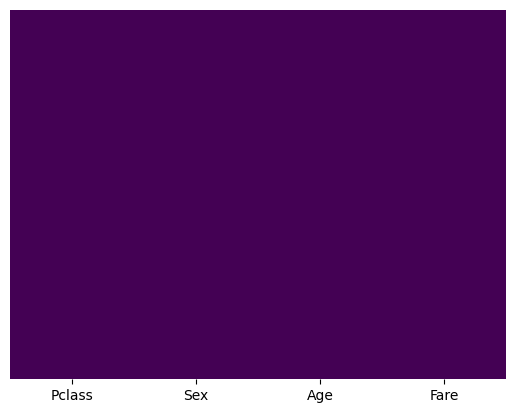

In [387]:
# Confirm that there is no missing data on the dataframe
sns.heatmap(test_X.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [388]:
test_predictions = log_reg.predict(test_X)
test_predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [389]:
# Add the Survived Column to the test dataset
df_titanic_test['Survived'] = test_predictions

In [390]:
# Print the dataframe
passengerId_survived = df_titanic_test[['PassengerId', 'Survived']]
passengerId_survived

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [391]:
# Save the dataframe to an excel document
passengerId_survived.to_csv("test_predicted_survived.csv", index=False)

In [392]:
print("Updated Test saved to test_with_predicted_survived.csv")

Updated Test saved to test_with_predicted_survived.csv


In [393]:
!ls -l /kaggle/working/

total 36
-rw-r--r-- 1 root root  2839 Dec  6 16:31 test_predicted_survived.csv
-rw-r--r-- 1 root root 29815 Dec  6 15:59 test_with_predicted_survived.csv
